<a href="https://colab.research.google.com/github/jysuhr/CRC_Simulation/blob/colabUpdate/CRC_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# 예시로 'california_housing_train.csv' 파일을 사용합니다. 다른 CSV 파일을 로드하려면 경로를 변경하세요.
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/CRC_Analytics/Summary_Report_Statistics.csv'

try:
    df = pd.read_csv(csv_file_path)
    print(f"'{csv_file_path}' 파일이 성공적으로 로드되었습니다.")
    display(df.head())
except FileNotFoundError:
    print(f"오류: '{csv_file_path}' 파일을 찾을 수 없습니다. 올바른 경로인지 확인하세요.")
except Exception as e:
    print(f"파일을 로드하는 중 오류가 발생했습니다: {e}")

'/content/drive/MyDrive/Colab Notebooks/CRC_Analytics/Summary_Report_Statistics.csv' 파일이 성공적으로 로드되었습니다.


,CRC,DataLength,ErrorPercent,ErrorDetectionRate_%,AverageDelay_ms
0,CRC8,16,0,0.0000,0.002717
1,CRC8,16,1,100.0000,0.002933
2,CRC8,16,10,100.0000,0.003010
3,CRC8,16,20,99.9512,0.002964
4,CRC8,16,50,99.3164,0.002927


## 📊 데이터 요약 테이블

In [ ]:
print('데이터프레임의 기술 통계량:')
display(df.describe())

데이터프레임의 기술 통계량:


,DataLength,ErrorPercent,ErrorDetectionRate_%,AverageDelay_ms
count,80.000000,80.0000,80.000000,80.000000
mean,135.000000,16.2000,79.909057,0.024084
std,126.390995,18.4942,40.207202,0.022894
min,16.000000,0.0000,0.000000,0.002717
25%,56.000000,1.0000,99.334700,0.009122
50%,96.000000,10.0000,100.000000,0.020251
75%,160.000000,20.0000,100.000000,0.030533
max,512.000000,50.0000,100.000000,0.096555


---

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## 📈 CRC 유형별 평균 Error Detection Rate 바 플롯

In [ ]:
# 1. 데이터 필터링: 에러율이 0%인 경우(탐지율 0%)를 제외하여 유효 평균을 계산합니다.
#    이는 알고리즘이 '에러가 있을 때' 얼마나 잘 작동하는지를 측정합니다.
df_filtered = df[df['ErrorPercent'] > 0].copy()

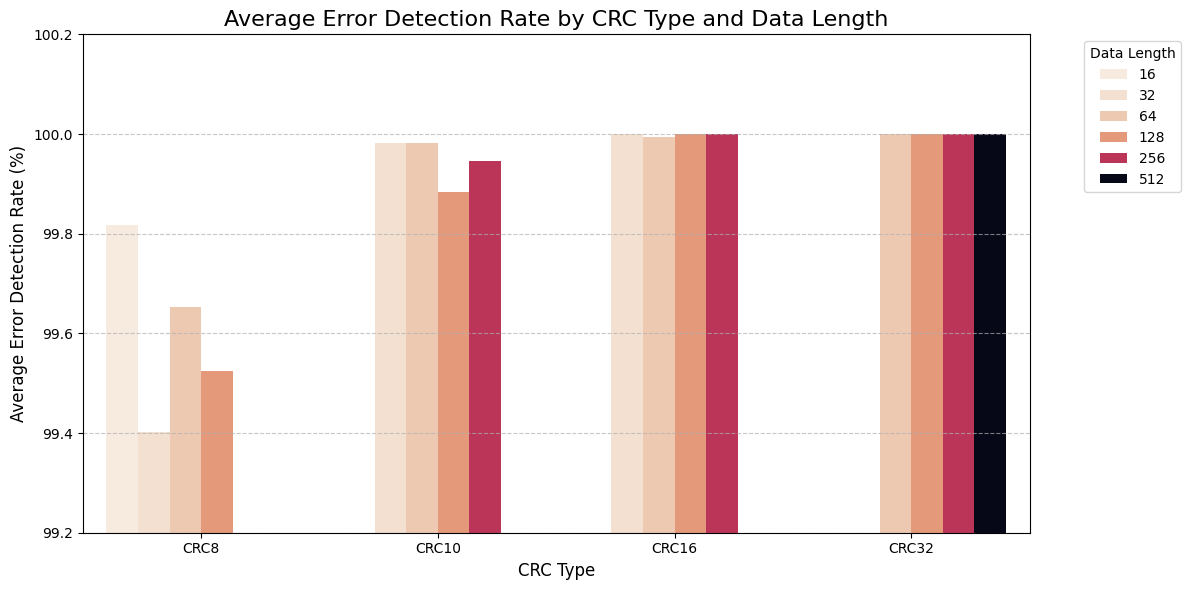

In [ ]:
plt.figure(figsize=(12, 6))

# 2. 필터링된 데이터프레임을 사용하여 막대 그래프 생성
#    estimator=lambda x: x.mean()은 각 (CRC, Data Length) 그룹에 대해
#    필터링된 DetectionRate_% 값들의 평균을 계산합니다.
sns.barplot(data=df_filtered,
            x='CRC',
            y='ErrorDetectionRate_%',
            estimator=lambda x: x.mean(), # 각 그룹의 평균 계산
            errorbar=None,
            palette='rocket_r',
            hue='DataLength')

# 3. 그래프 설정
plt.title('Average Error Detection Rate by CRC Type and Data Length', fontsize=16)
plt.xlabel('CRC Type', fontsize=12)
plt.ylabel('Average Error Detection Rate (%)', fontsize=12)

# y축 범위를 79.5% ~ 80.1%로 설정하여 미세한 차이를 강조
plt.ylim(99.2, 100.2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 🔥 CRC 유형 및 Data Length별 평균 Error Detection Rate 히트맵

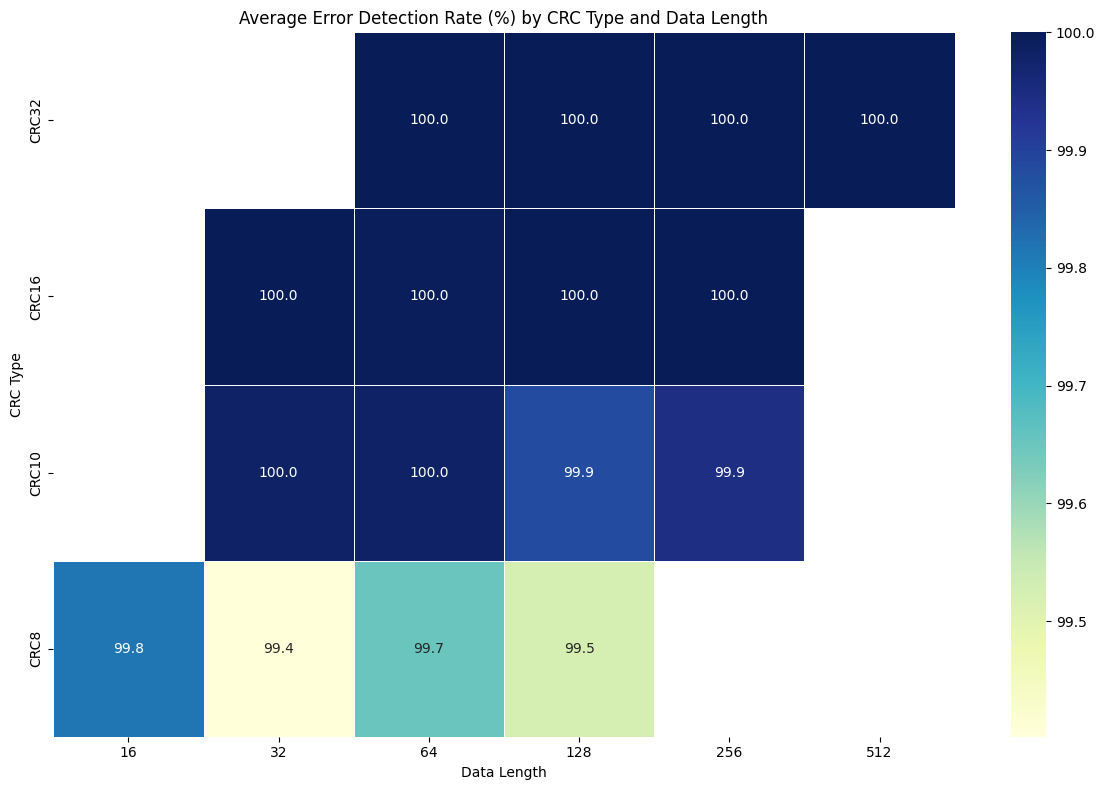

In [ ]:
pivot_table = df_filtered.pivot_table(index='CRC', columns='DataLength', values='ErrorDetectionRate_%', aggfunc='mean')
custom_crc_order = ['CRC32', 'CRC16', 'CRC10', 'CRC8']
pivot_table = pivot_table.reindex(custom_crc_order)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Average Error Detection Rate (%) by CRC Type and Data Length')
plt.xlabel('Data Length')
plt.ylabel('CRC Type')
plt.tight_layout()
plt.show()

---

## 🎻 Data Length별 Average Delay Violin Plot

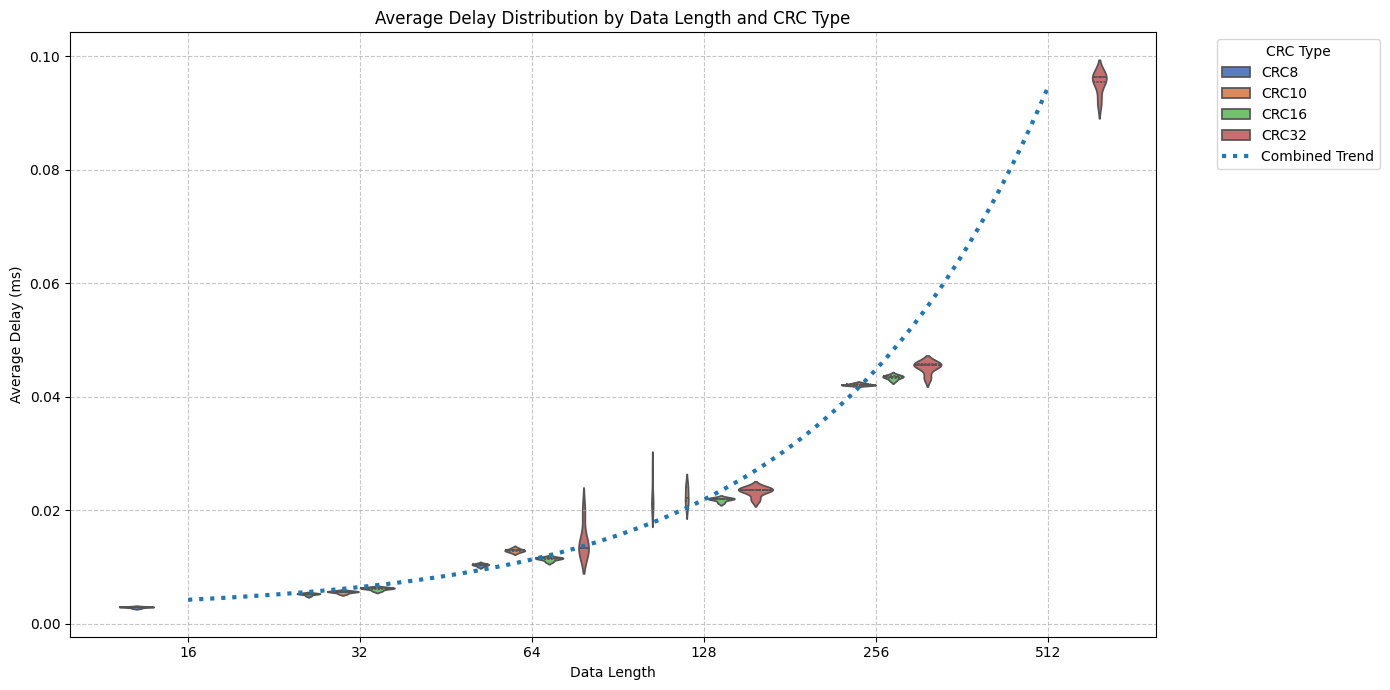

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

# 지수 함수 정의
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

plt.figure(figsize=(14, 7))

# 바이올린 플롯 그리기
sns.violinplot(data=df, x='DataLength', y='AverageDelay_ms', hue='CRC',
               palette='muted', inner='quartile')

# 모든 CRC를 합친 데이터로 하나의 추세선 생성
data_lengths_unique = df['DataLength'].unique()
x_positions = {length: i for i, length in enumerate(data_lengths_unique)}

# 모든 데이터 포인트 수집
all_x = []
all_y = []
for length in data_lengths_unique:
    length_data = df[df['DataLength'] == length]['AverageDelay_ms']
    all_x.extend([x_positions[length]] * len(length_data))
    all_y.extend(length_data.values)

all_x = np.array(all_x)
all_y = np.array(all_y)

# 지수 함수 피팅
try:
    initial_guess = [0.355019, 0.000468, -0.355136]
    popt, _ = curve_fit(exponential_func, all_x, all_y,
                       p0=initial_guess, maxfev=10000)

    # 추세선 그리기
    x_line = np.linspace(min(all_x), max(all_x), 100)
    y_line = exponential_func(x_line, *popt)

    plt.plot(x_line, y_line, ':', linewidth=3,
            label='Combined Trend')

except RuntimeError:
    print("Could not fit exponential curve")

plt.title('Average Delay Distribution by Data Length and CRC Type')
plt.xlabel('Data Length')
plt.ylabel('Average Delay (ms)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='CRC Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 📊 CRC8: Error Percentage별 Error Detection Rate

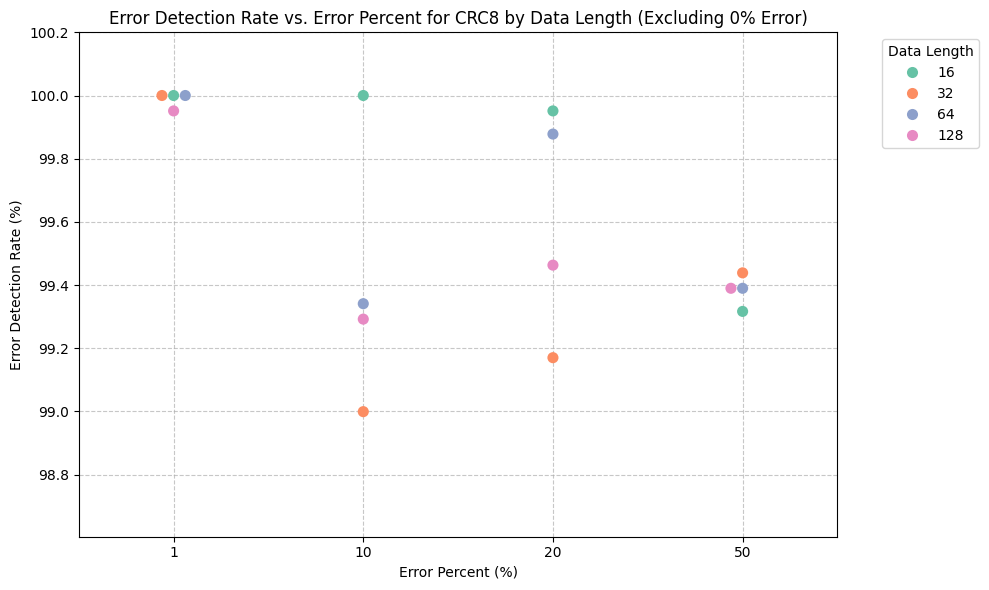

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# CRC8 데이터만 필터링하고 ErrorPercent가 0인 값 제외
df_crc8 = df[(df['CRC'] == 'CRC8') & (df['ErrorPercent'] != 0)]

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_crc8, x='ErrorPercent', y='ErrorDetectionRate_%', hue='DataLength', palette='Set2', s=8)
plt.title('Error Detection Rate vs. Error Percent for CRC8 by Data Length (Excluding 0% Error)')
plt.xlabel('Error Percent (%)')
plt.ylabel('Error Detection Rate (%)')
plt.ylim(min(df_crc8['ErrorDetectionRate_%']) * 0.996, max(df_crc8['ErrorDetectionRate_%']) * 1.002)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 📊 CRC10: Error Percentage별 Error Detection Rate

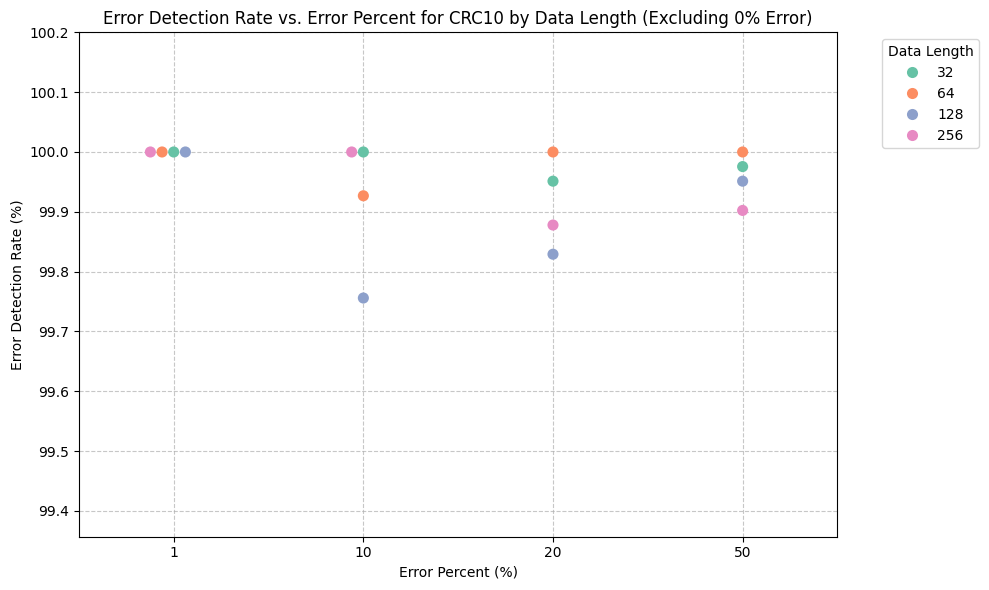

In [ ]:
# CRC10 데이터만 필터링하고 ErrorPercent가 0인 값 제외
df_crc10 = df[(df['CRC'] == 'CRC10') & (df['ErrorPercent'] != 0)]

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_crc10, x='ErrorPercent', y='ErrorDetectionRate_%', hue='DataLength', palette='Set2', s=8)
plt.title('Error Detection Rate vs. Error Percent for CRC10 by Data Length (Excluding 0% Error)')
plt.xlabel('Error Percent (%)')
plt.ylabel('Error Detection Rate (%)')
plt.ylim(min(df_crc10['ErrorDetectionRate_%']) * 0.996, max(df_crc10['ErrorDetectionRate_%']) * 1.002)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 📊 CRC16: Error Percentage별 Error Detection Rate

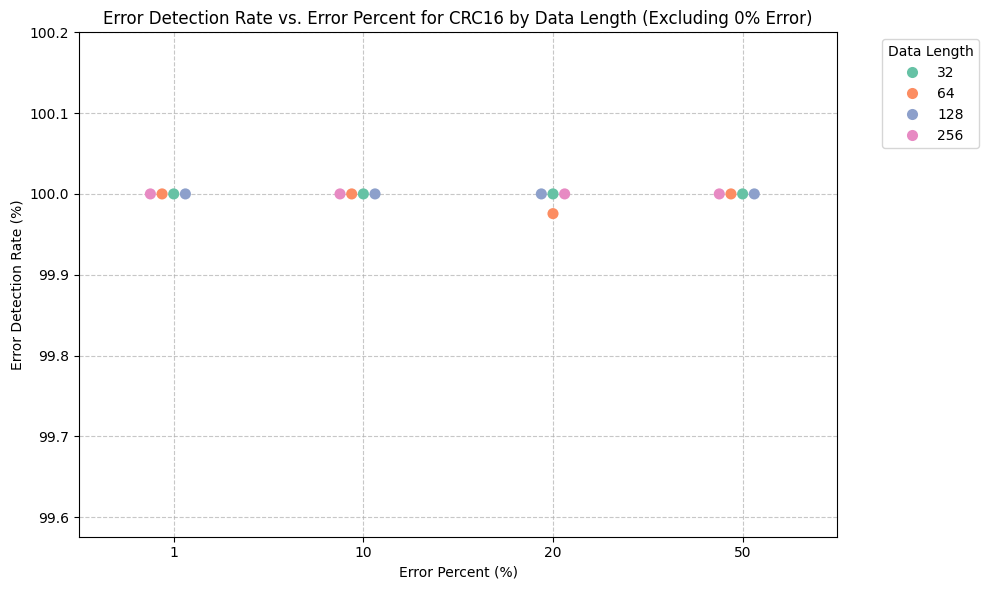

In [ ]:
# CRC16 데이터만 필터링하고 ErrorPercent가 0인 값 제외
df_crc16 = df[(df['CRC'] == 'CRC16') & (df['ErrorPercent'] != 0)]

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_crc16, x='ErrorPercent', y='ErrorDetectionRate_%', hue='DataLength', palette='Set2', s=8)
plt.title('Error Detection Rate vs. Error Percent for CRC16 by Data Length (Excluding 0% Error)')
plt.xlabel('Error Percent (%)')
plt.ylabel('Error Detection Rate (%)')
plt.ylim(min(df_crc16['ErrorDetectionRate_%']) * 0.996, max(df_crc16['ErrorDetectionRate_%']) * 1.002)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 📊 CRC32: Error Percentage별 Error Detection Rate

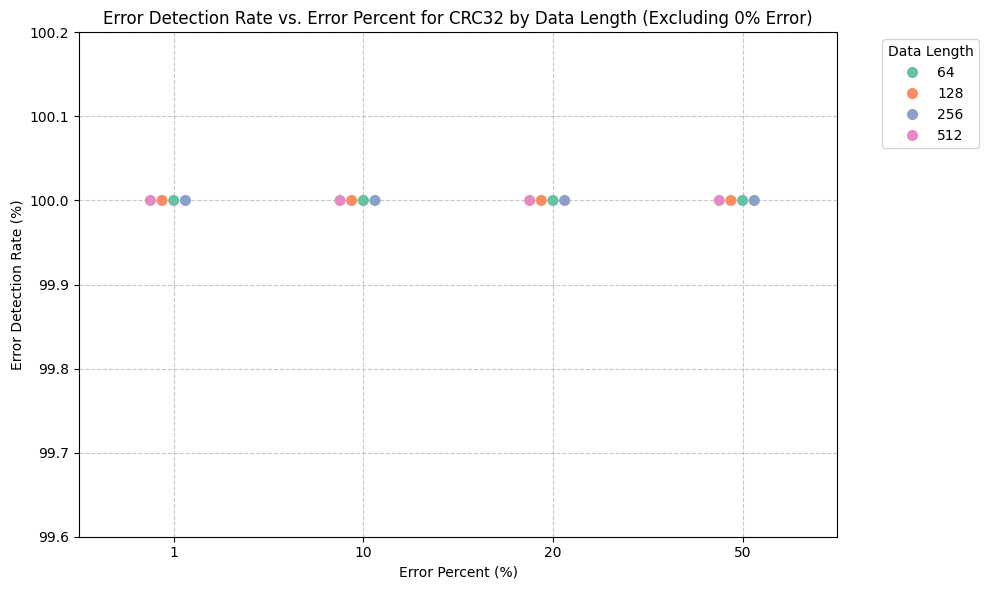

In [ ]:
# CRC32 데이터만 필터링하고 ErrorPercent가 0인 값 제외
df_crc32 = df[(df['CRC'] == 'CRC32') & (df['ErrorPercent'] != 0)]

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_crc32, x='ErrorPercent', y='ErrorDetectionRate_%', hue='DataLength', palette='Set2', s=8)
plt.title('Error Detection Rate vs. Error Percent for CRC32 by Data Length (Excluding 0% Error)')
plt.xlabel('Error Percent (%)')
plt.ylabel('Error Detection Rate (%)')
plt.ylim(min(df_crc32['ErrorDetectionRate_%']) * 0.996, max(df_crc32['ErrorDetectionRate_%']) * 1.002)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

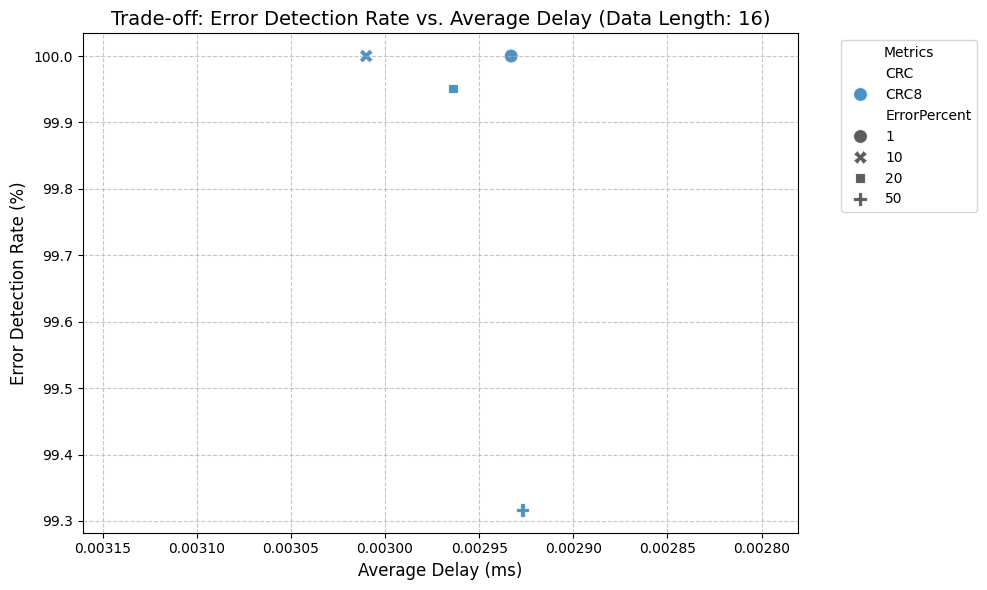

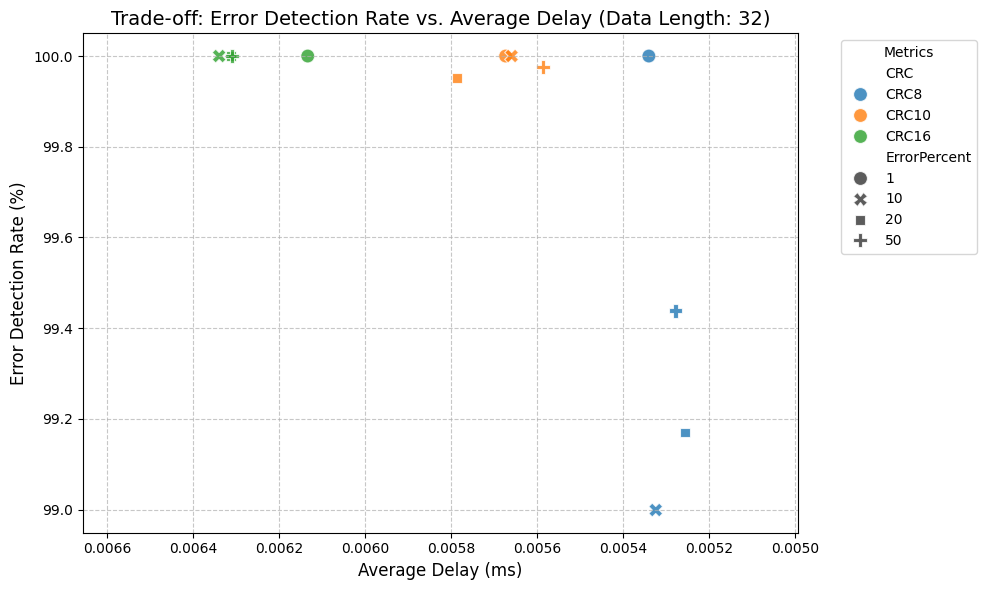

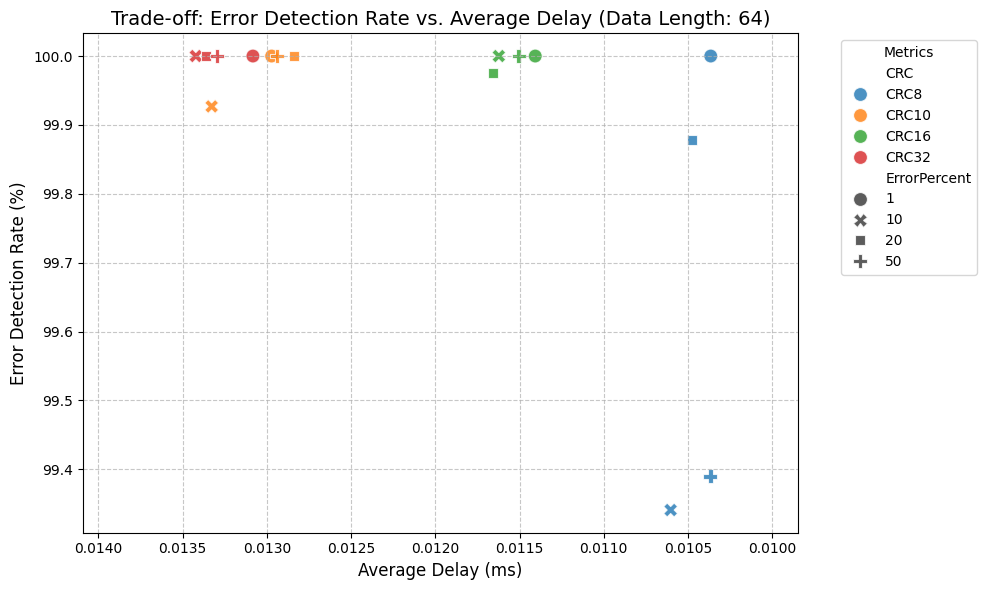

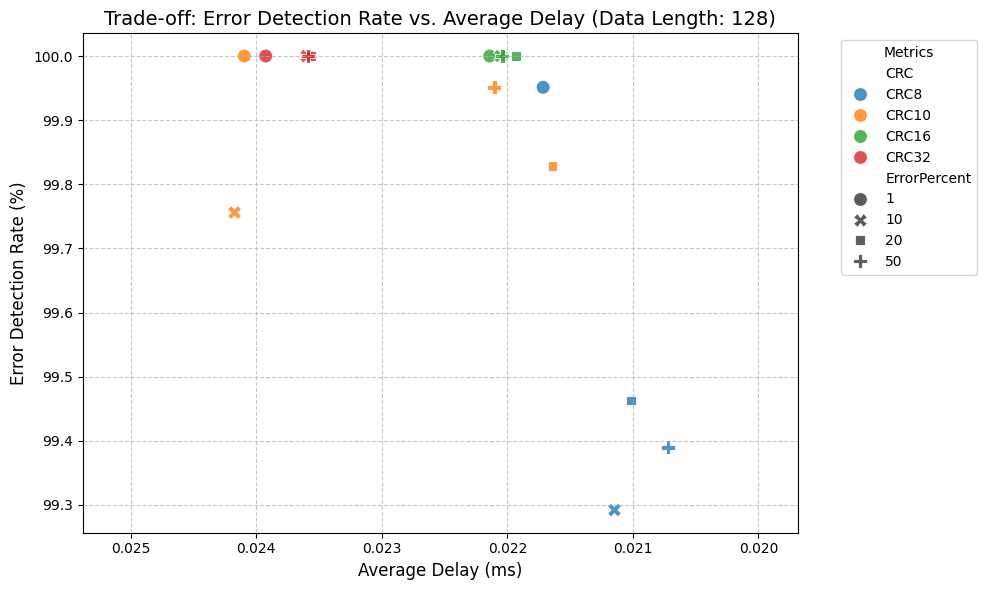

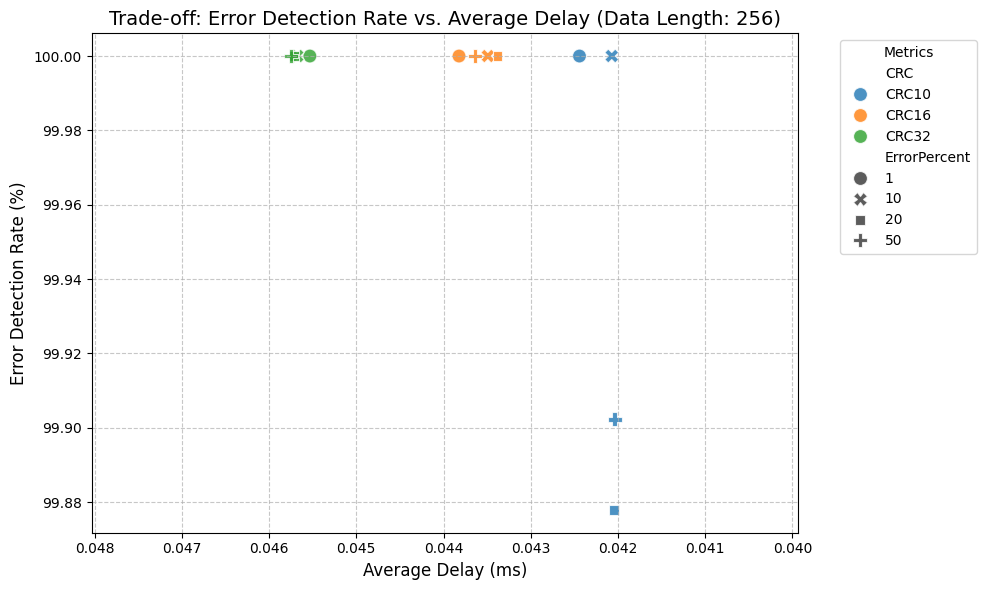

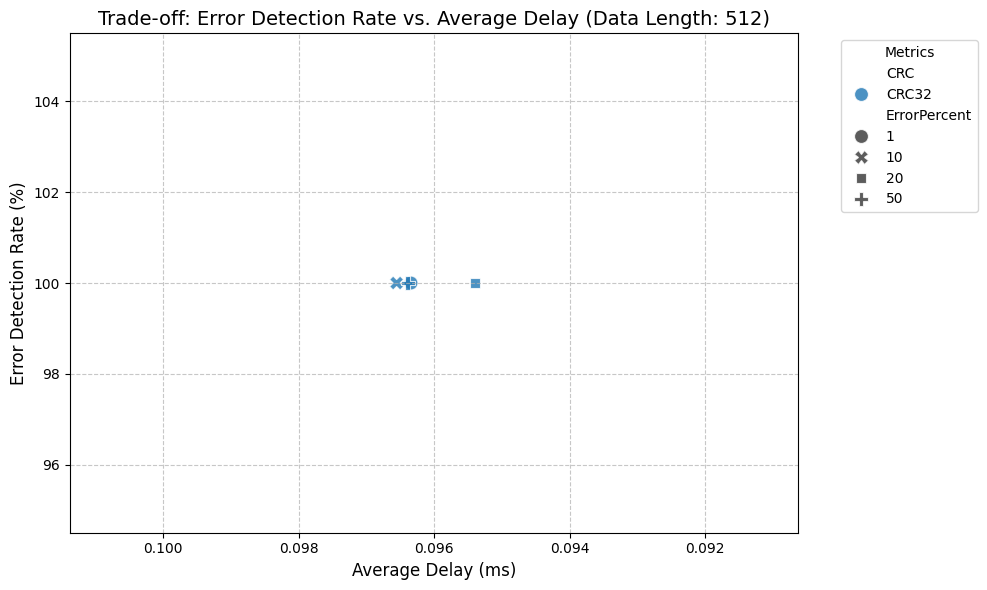

In [ ]:
unique_data_lengths = df_filtered['DataLength'].unique()
unique_data_lengths.sort() # 데이터 길이를 오름차순으로 정렬하여 일관된 순서 유지

for data_length in unique_data_lengths:
    df_subset = df_filtered[df_filtered['DataLength'] == data_length]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_subset,
                    x='AverageDelay_ms',
                    y='ErrorDetectionRate_%',
                    hue='CRC',
                    style='ErrorPercent', # ErrorPercent에 따라 점의 모양 변경
                    s=100, # 점 크기
                    alpha=0.8) # 투명도 조절

    plt.title(f'Trade-off: Error Detection Rate vs. Average Delay (Data Length: {data_length})', fontsize=14)
    plt.xlabel('Average Delay (ms)', fontsize=12)
    plt.ylabel('Error Detection Rate (%)', fontsize=12)

    # x축 뒤집기 (최댓값, 최솟값 순서로 설정)
    min_delay = df_subset['AverageDelay_ms'].min()
    max_delay = df_subset['AverageDelay_ms'].max()
    plt.xlim(max_delay * 1.05, min_delay * 0.95)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례 제목 변경
    plt.tight_layout()
    plt.show()